# Supporting Information for 
# "Euphotic zone residence time of Antarctic Bottom Water"

### Code for Figure S1
Location where the AABW particles passed through the 1000m isobath contour curtain in year0 (i.e., 2005 in model).

Corresponding to Yinghuan Xie (yinghuan.xie@utas.edu.au)

In [1]:
# Importing the relevant modules. 
import numpy as np
import xarray as xr
import os
import re
from glob import glob
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cosima_cookbook as cc
session =cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'
from os import sys
sys.path.append('/home/581/yx9454/PhD_Ch1')
from My_Py_Func import Ch1_defs as c1d

In [2]:
def PDF3D(x,y,z,res,z_edge,npts):
  x_here = x.flatten()
  y_here = y.flatten()
  z_here = z.flatten()
  #p_here = psigma2.flatten()

  if res==0.1:
    x_edges,y_edges = np.arange(0,360.1,0.1),np.arange(-80,-29.9,0.1)
    Three_dim_PDF,edges = np.histogramdd((x_here,y_here,z_here),(x_edges,y_edges,z_edge))
    Three_dim_PDF = (Three_dim_PDF/npts)*100
    #
    boxcenter = [edges[0][:-1]+(0.5*abs(edges[0][0]-edges[0][1])),
                 edges[1][:-1]+(0.5*abs(edges[1][0]-edges[1][1])),
                 edges[2][:-1]+(0.5*abs(edges[2][0]-edges[2][1]))]
    X,Y = np.meshgrid(boxcenter[0], boxcenter[1])
    print('RES=0.1 deg')

  elif res==1:
    x_edges,y_edges = np.arange(0,361,1),np.arange(-80,-29,1)
    Three_dim_PDF,edges = np.histogramdd((x_here,y_here,z_here),(x_edges,y_edges,z_edge))
    hree_dim_PDF = (Three_dim_PDF/npts)*100
    #
    boxcenter = [edges[0][:-1]+(0.5*abs(edges[0][0]-edges[0][1])),
                 edges[1][:-1]+(0.5*abs(edges[1][0]-edges[1][1])),
                 edges[2][:-1]+(0.5*abs(edges[2][0]-edges[2][1]))]
    X,Y = np.meshgrid(boxcenter[0], boxcenter[1])
    print('RES=1 deg')

  else:
    print('Plz choose 0.1 or 1 or build a new def')

  return(X,Y,Three_dim_PDF)

def plot_3D_PDF_section_ccrs_v2a(imput_array,X,Y,cmap_here,cmin,cmax,lower_limit,title,fig_name,str_dep,rel_pos_mak_x,rel_pos_mak_y):
    fig = plt.figure(num=1,figsize=(15, 15))
    ax = plt.subplot(projection=ccrs.SouthPolarStereo())

    c_min,c_max = cmin,cmax
    levels = np.linspace(c_min,c_max,65)
    imput_array[imput_array<=lower_limit] = np.nan #make 0's invalid so they don't show up on plot
    ffmsk = np.ma.masked_invalid(imput_array)
    ax.pcolormesh(np.transpose(X), np.transpose(Y), ffmsk,cmap=cmap_here,vmax=c_max,vmin=c_min,zorder=5,
                  transform=ccrs.PlateCarree()) #It was YlGnBu

    # Isobath and background
    X,Y = np.meshgrid(xt_ocean,yt_extend)
    ax.contourf(X,Y,np.ma.masked_greater(ocean_depth_extend,0),colors='gray',zorder=11,transform=ccrs.PlateCarree()) #Land Mask cmap=cmap_ice
    ax.contour(X, Y,ocean_depth_extend,[1],colors='black',linewidths=0.5,zorder=12,transform=ccrs.PlateCarree()) #isoheight of ocean
    #
    if str_dep !=0:
        ax.contourf(X,Y,np.ma.masked_outside(ocean_depth_extend,-1,str_dep),colors='silver',zorder=10,transform=ccrs.PlateCarree()) #Land Mask cmap=cmap_ice
    #
    ax.scatter(rel_pos_mak_x,rel_pos_mak_y,zorder=15,color='red',transform=ccrs.PlateCarree())
    
    
    #
    ax.contour(xt_ocean_cc, yt_ocean_cc, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree(),zorder=15)
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    #
    plt.title(title)
    plt.savefig(fig_name+'.png',format='png',dpi=300)
    plt.show()

def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')

    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']

    # in this file the points along the isobath are given a positive value, the points outside (northwards)
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0
    # so we mask for the 0 values
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

    # then we want to multiply the variable with the mask so we need to account for the shape of the mask.
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

In [3]:
# In each experiment, we define 06-18, release-06, 05-release, 87-05,
# loop_start_point-87 (if availiable) as No 0,1,2,3,4(if availiable)

master_path = '/g/data/jk72/yx9454/runs/parcels/output_after_Aug/'
traj_input = {'MLS_ON':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_ON/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_Loop_MLS_ON/'}],
        }

In [4]:
%%time
exp_name = 'MLS_ON'

# Load traj files 0
# From 5days freq npz file

var_in_arrs_0 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_0_CS_Eu_date.npz')
var_in_arrs_0['CS_Eu_date']=npzfile['CS_Eu_date']


# Load traj files 1
# From 5days freq npz file
var_in_arrs_1 = {}
npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_1.npz')
var_in_arrs_1['x']   =npzfile['x']
var_in_arrs_1['y']   =npzfile['y']
var_in_arrs_1['z'] = npzfile['z']

npzfile = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/'+exp_name+'/var_in_arrs_1_CS_Eu_date.npz')
var_in_arrs_1['CS_Eu_date']=npzfile['CS_Eu_date']



CPU times: user 2.91 s, sys: 2.46 s, total: 5.37 s
Wall time: 7.15 s


In [5]:
AABW_inds = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/AABW_inds.npz')['AABW_inds']
stopsign_list = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/stopsign_list_for_20yrs_150m_thre.npz')['stopsign_list']
CDW_inds = ~(np.isnan(stopsign_list))
AABW_shallower_than_EZD_plus_CDW =  (var_in_arrs_0['CS_Eu_date'][:,-1]>0) & (CDW_inds)

print('AABW: ',sum(AABW_inds))
print('AABW_CDW: ',sum(CDW_inds))
print('AABW&EZD: ',sum(var_in_arrs_0['CS_Eu_date'][:,-1]>0))
print('AABW&cdw&EZD: ',sum(AABW_shallower_than_EZD_plus_CDW))

AABW:  94123
AABW_CDW:  88809
AABW&EZD:  41013
AABW&cdw&EZD:  36161


In [6]:
# This chunk is to select the first non-nan value in each row, which is the initial position of paricles
mask = np.concatenate((np.expand_dims(np.isnan(var_in_arrs_1['x'][AABW_inds])[:,-1], axis=1),
                np.isnan(var_in_arrs_1['x'][AABW_inds])[:,:-1]),
               axis=1)
tar_array_x = var_in_arrs_1['x'][AABW_inds][mask]
tar_array_x = tar_array_x[~np.isnan(tar_array_x)]

tar_array_y = var_in_arrs_1['y'][AABW_inds][mask]
tar_array_y = tar_array_y[~np.isnan(tar_array_y)]

tar_array_z = var_in_arrs_1['z'][AABW_inds][mask]
tar_array_z = tar_array_z[~np.isnan(tar_array_z)]

# This chunk is to select the first non-nan value in each row, which is the initial position of paricles
mask = np.concatenate((np.expand_dims(np.isnan(var_in_arrs_1['x'][:])[:,-1], axis=1),
                np.isnan(var_in_arrs_1['x'][:])[:,:-1]),
               axis=1)
tar_array_x_total = var_in_arrs_1['x'][:][mask]
tar_array_x_total = tar_array_x_total[~np.isnan(tar_array_x_total)]

tar_array_y_total = var_in_arrs_1['y'][:][mask]
tar_array_y_total = tar_array_y_total[~np.isnan(tar_array_y_total)]

tar_array_z_total = var_in_arrs_1['z'][:][mask]
tar_array_z_total = tar_array_z_total[~np.isnan(tar_array_z_total)]


## Figure S1. b

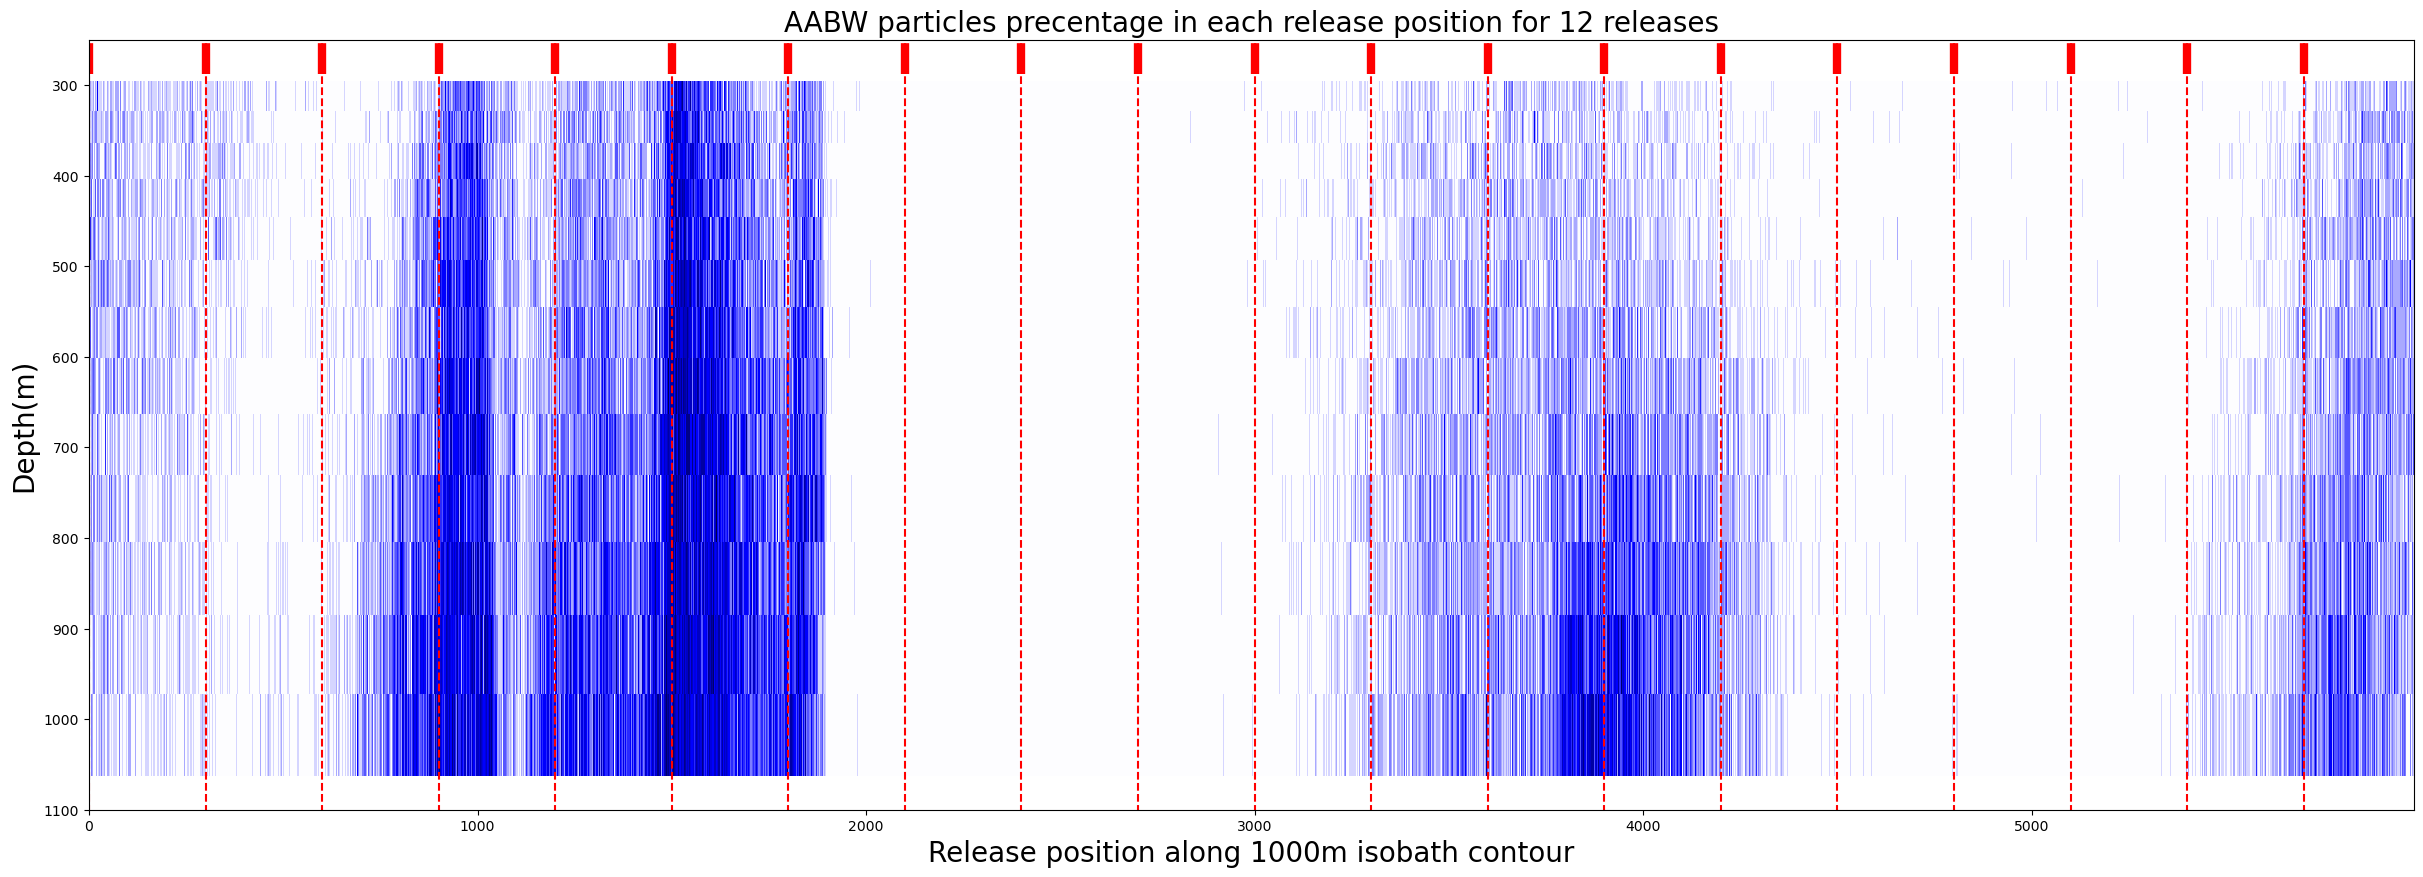

In [7]:
ffmsk = np.array(np.split(AABW_inds,12*13)[13*(1-1):13*1])
for mm in (np.arange(12)+1)[1:]:
    ffmsk = ffmsk +  1*np.array(np.split(AABW_inds,12*13)[13*(mm-1):13*mm])
    #print(mm)
# Get mean
ffmsk = ffmsk/12

plt.figure(figsize=(30,10))
x_axis = np.arange(ffmsk.shape[1])
z_axis = (np.array(np.split(tar_array_z_total,12*13)[13*(mm-1):13*mm]))[:,0]
plt.ylim([1100,250])
plt.pcolormesh(x_axis,z_axis,ffmsk,cmap='seismic_r',vmin=-1,vmax=1)
for x_pos in x_axis[::300]:
    plt.plot(np.ones(10)*x_pos,np.arange(200,300,10),'r--',lw=6)
    plt.plot(np.ones(10)*x_pos,np.arange(200,1200,100),'r--')
plt.xlabel('Release position along 1000m isobath contour',fontsize=20)
plt.ylabel('Depth(m)',fontsize=20)
plt.title('AABW particles precentage in each release position for 12 releases',fontsize=20)
plt.savefig('Figure_S1_b',dpi=300)


## Figure S1. C

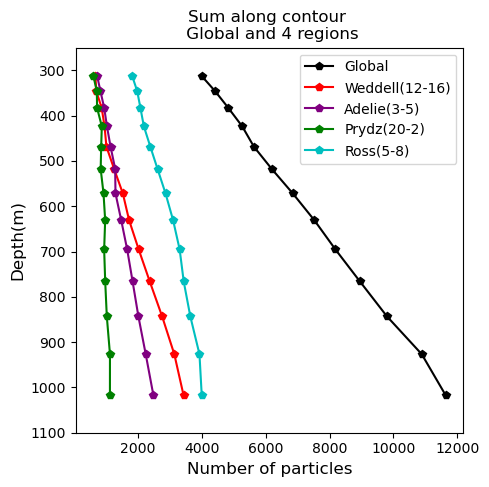

In [8]:
ffmsk = np.array(np.split(AABW_inds,12*13)[13*(1-1):13*1])
for mm in (np.arange(12)+1)[1:]:
    ffmsk = ffmsk +  1*np.array(np.split(AABW_inds,12*13)[13*(mm-1):13*mm])
    #print(mm)
# Get mean
ffmsk = ffmsk
x_axis = np.arange(ffmsk.shape[1])
z_axis = (np.array(np.split(tar_array_z_total,12*13)[13*(mm-1):13*mm]))[:,0]
#------------------------------------------
plt.figure(figsize=(5,5))
plt.plot(np.sum(ffmsk,axis=1),z_axis,'k-p',label='Global')
#Wedd
plt.plot(np.sum(ffmsk[:,x_axis[::300][11]:x_axis[::300][15]],axis=1),z_axis,'r-p',label='Weddell(12-16)')
#Adelie
plt.plot(np.sum(ffmsk[:,x_axis[::300][2]:x_axis[::300][4]],axis=1),z_axis,'-p',label='Adelie(3-5)',c='purple')
#Prydz
Prydz_ffmsk= np.sum(ffmsk[:,x_axis[::300][19]:],axis=1)+np.sum(ffmsk[:,:x_axis[::300][1]],axis=1)
plt.plot(Prydz_ffmsk,z_axis,'g-p',label='Prydz(20-2)')
#Ross
plt.plot(np.sum(ffmsk[:,x_axis[::300][4]:x_axis[::300][7]],axis=1),z_axis,'c-p',label='Ross(5-8)')
plt.ylim([1100,250])
plt.xlabel('Number of particles',fontsize=12)
plt.ylabel('Depth(m)',fontsize=12)
plt.title('Sum along contour \n Global and 4 regions',fontsize=12)
plt.legend()
plt.savefig('Figure_S1_c.png',dpi=300)


In [9]:

# Define the density threshold
p_layers_here = [0,9000]



all_following_x = tar_array_x_total
all_following_y = tar_array_y_total
all_following_z = np.ones(all_following_y.shape)
#
npts = all_following_x.shape[0]
print('npts:',npts)
X,Y,Three_dim_PDF_total = PDF3D(all_following_x,all_following_y,all_following_z,1,p_layers_here,npts)




all_following_x = tar_array_x_total[AABW_inds]
all_following_y = tar_array_y_total[AABW_inds]
all_following_z = np.ones(all_following_y.shape)
#
npts = all_following_x.shape[0]
print('npts:',npts)
X,Y,Three_dim_PDF = PDF3D(all_following_x,all_following_y,all_following_z,1,p_layers_here,npts)

ffmsk = Three_dim_PDF/Three_dim_PDF_total

npts: 933504
RES=1 deg
npts: 94123
RES=1 deg


## Figure S1. a
### Load Grid data for later processing

In [10]:
#This is for plotting 20 markers along teh contour
rel_pos_mak_y = np.array([-65.96582031, -64.04801941, -65.54342651, -65.58567047,
       -67.82435608, -71.92156982, -74.58264923, -76.14550781,
       -73.10427094, -71.07678223, -69.68288422, -64.09174347,
       -61.19955063, -67.73987579, -73.73786163, -72.63964081,
       -69.72512817, -70.02079773, -68.03555298, -66.55717468])
rel_pos_mak_x = np.array([ 80.1000061 , 100.20001221, 120.69999695, 141.        ,
       157.69999695, 172.69999695, 183.30000305, 206.8999939 ,
       229.        , 251.80000305, 276.59999847, 293.40000153,
       306.29999924, 304.40000153, 318.59999847, 340.79999924,
         1.10000002,  22.29999924,  40.20000076,  59.5       ])
#-------------------------------------------------------------------------------------

xt_ocean,yt_ocean,yt_extend,ocean_depth,ocean_depth_extend = c1d.Load_Grid_Data(False)
# Grid inherited from CC Code
ht = cc.querying.getvar(expt,'ht', session, n=1)
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean_cc = ht.yt_ocean.values
xt_ocean_cc = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

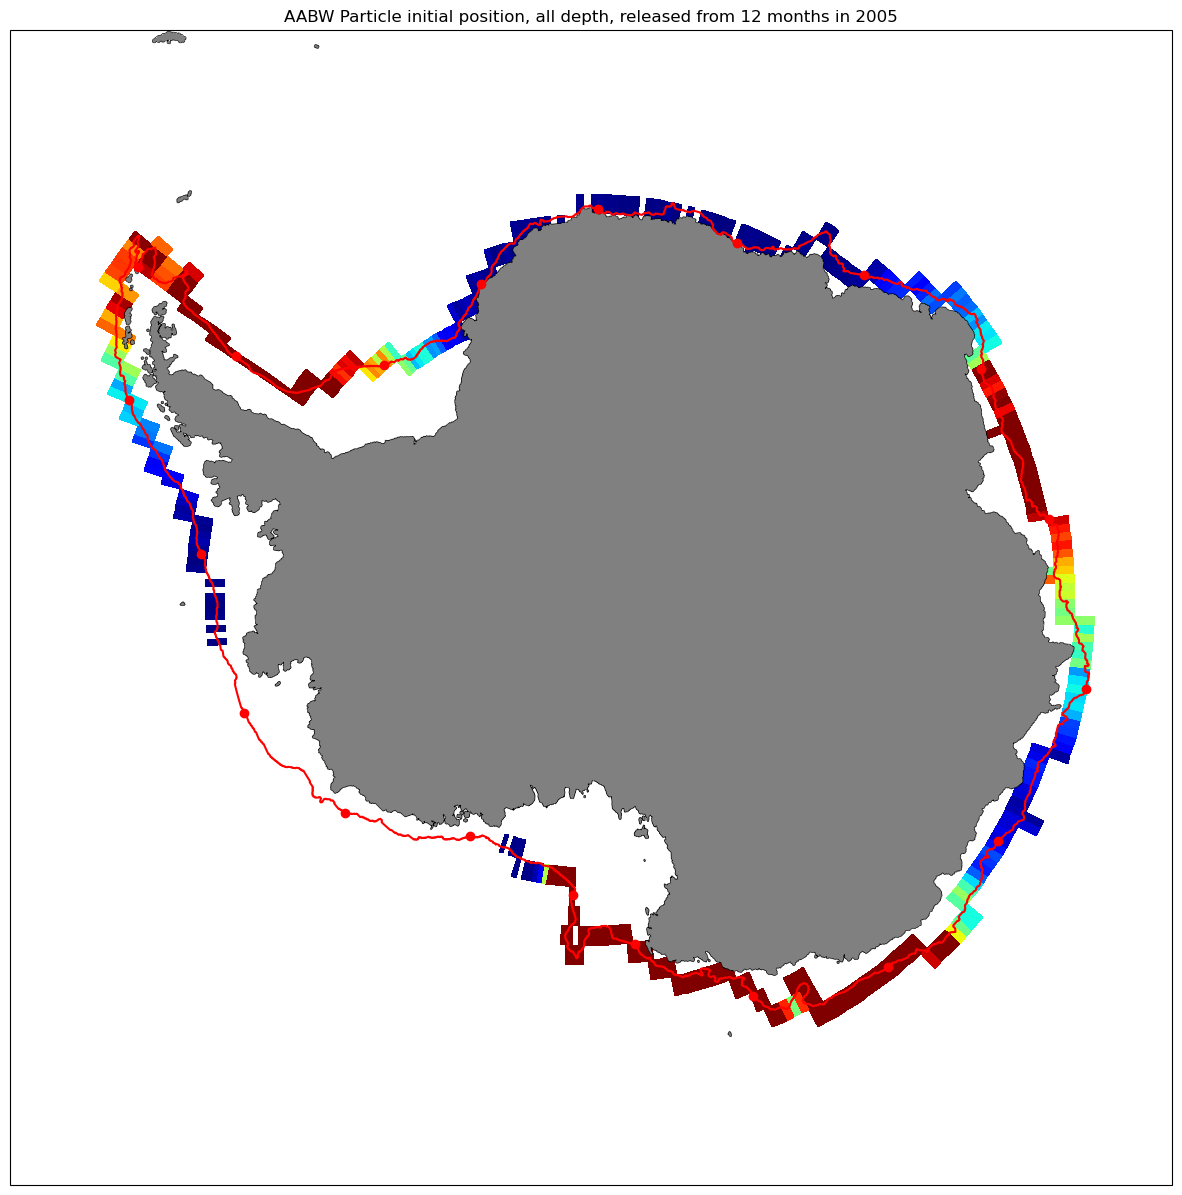

In [11]:
#Define title and file name
title= 'AABW Particle initial position, all depth, released from 12 months in 2005'

fig_name='Figure S1'

#Plot
plot_3D_PDF_section_ccrs_v2a(ffmsk[:, :, 0], X, Y, 'jet', cmin=0.00001,cmax=0.15,lower_limit=0.00001,
    title=title,
    fig_name=fig_name,str_dep=0,
    rel_pos_mak_x=rel_pos_mak_x,rel_pos_mak_y=rel_pos_mak_y)